In [1]:
import tifffile as tf
from scipy import ndimage
from scipy import spatial
from scipy import special
import numpy as np
import pandas as pd

import os
import glob
import itertools as it
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
src = '../hpcc/'
dst = '../hpcc/traditional/'

wsrc = src + 'clean/'
tsrc = src + 'watershed/'
rsrc = src + 'rotated/'

fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

In [3]:
idname = 'SelectD'

rownum = 9
treenum = 1
nutnum = 4

bname = idname + '_R{}_T{}'.format(rownum, treenum)
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)

SelectD_R9_T1_004


In [4]:
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

img = tf.imread(wsrc + bname + '/' + fname + '.tif')
tissuefiles = tsrc + bname + '/' + fname + '_'

if True:
    air  = tf.imread(tissuefiles + 'air.tif')
    meat = tf.imread(tissuefiles + 'meat.tif')
    shell= tf.imread(tissuefiles + 'shell.tif')
    vein = tf.imread(tissuefiles + 'vein.tif')
    protrusion = tf.imread(tissuefiles + 'protrusion.tif')
    
    extshell = np.zeros_like(shell, dtype=np.bool)
    extshell[protrusion == 3] = True

SelectD_R9_T1_004


### Load rotations and phenotypes

In [5]:
filename = rsrc + bname + '/' + fname + '_rotation.csv'
data = np.loadtxt(filename, delimiter=',')

wmean = data[0]
rotxyz = data[10:13]
rotX, _, _ = data[13]
tipvox = data[14]
rtipvox = data[15]
feretd = data[18]
nutvol, nutarea, nutvoxarea = data[19]
#nutvoxarea *= resol**2
chnutarea, chnutvol, _ = data[20]

tipvox[0] *= 1 + (-2*rotX)

chnutaratio = chnutarea/nutarea
chnutvratio = chnutvol/nutvol

In [6]:
print('Feret:\t', np.round(feretd,1), '\n')
print('*****', 'A[mm^2]', 'V[mm^3]', sep='\t')
print('Walnut', np.round(nutarea), np.round(nutvol), sep='\t')
print('Hull', np.round(chnutarea), np.round(chnutvol), sep='\t')
print('Hull/W', np.round(chnutaratio,3), np.round(chnutvratio,3), sep='\t')
####
print('\nVol Approx by a box of side:\t', np.round(np.cbrt(nutvol),2), 'mm')
print('Vol Approx by a ball of diam:\t', np.round(2*np.cbrt(3*nutvol/(4*np.pi)),2), 'mm')
####
print('\nArea Approx by a box of side:\t', np.round(np.sqrt(nutarea/6),2), 'mm')
print('Area Approx by a ball of diam:\t', np.round(2*np.sqrt(nutarea/(4*np.pi)),2), 'mm')

Feret:	 [40.5 34.  32.5] 

*****	A[mm^2]	V[mm^3]
Walnut	6179.0	21061.0
Hull	3850.0	21827.0
Hull/W	0.623	1.036

Vol Approx by a box of side:	 27.62 mm
Vol Approx by a ball of diam:	 34.26 mm

Area Approx by a box of side:	 32.09 mm
Area Approx by a ball of diam:	 44.35 mm


### Other phenotypes

In [7]:
tvols = np.zeros(4)
for i,tissue in enumerate([air, meat, shell, vein]):
    tvols[i] = np.sum(tissue > 0)

tvols = tvols.astype(float)*(resol**3)

tvolr = tvols/nutvol
print(np.round(tvolr*100,2), np.round(np.sum(tvolr)), sep='\n')

[35.71 35.63 17.67 10.99]
1.0


### Sphericity

In [8]:
nutva3d = (nutarea ** 3)/(36*np.pi*nutvol**2)
nutferet = np.max(feretd)/np.min(feretd)
nutsphr = np.cbrt(36 * np.pi * nutvol**2)/nutarea
shellrug = 1./nutsphr

In [9]:
c,b,a = np.sort(feretd)*.5

if a == c:
    area = 4*np.pi*a*a
else:
    t = np.arccos(c/a)
    s = np.arccos(c/b)
    k = np.sin(s)/np.sin(t)

    ellarea = c*c/(a*a)*special.ellipkinc(t, k*k) + np.sin(t)*np.sin(t)*special.ellipeinc(t, k*k)
    ellarea *= 2*np.pi*a*b/np.sin(t)
    ellarea += 2*np.pi*c*c

ellvolume = 4*np.pi*a*b*c/3

wadell = np.cbrt(36*np.pi*ellvolume*ellvolume)/ellarea

In [13]:
krumbein = np.cbrt(b*c/(a*a))
corey = c/np.sqrt(a*b)
sneed = np.cbrt(c*c/(a*b))
janke = c/np.sqrt((a**2 + b**2 + c**2)/3)

print('{:.2f}\t{:.2f}\t{:.2f}'.format(a,b,c))
print(np.round([nutsphr, wadell, krumbein, corey, sneed, janke, c/a],3), sep='\t')

20.27	16.98	16.26
[0.597 0.993 0.876 0.876 0.916 0.907 0.802]


### Kernel lobeyness

In [68]:
bimg = meat.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
kerarea = np.sum(border) * (resol ** 2)
border[border > 0] = 1
kervoxarea = np.sum(border)

print('Border made of\t', kervoxarea, 'pixels\n')
print('Nut surface area:\t', np.round(kerarea, 2), 'mm^2')
print('Approx by a square of size:\t', np.round(np.sqrt(kerarea),2), 'mm')

Border made of	 791280 pixels

Nut surface area:	 7703.39 mm^2
Approx by a square of size:	 87.77 mm


In [15]:
datapoints = np.asarray(np.nonzero(border))
datapoints = datapoints - wmean.reshape(-1,1)
datapoints *= resol

mcoords = rotxyz @ datapoints

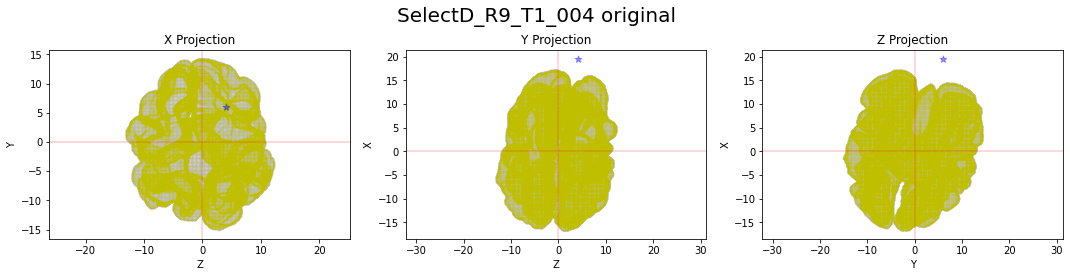

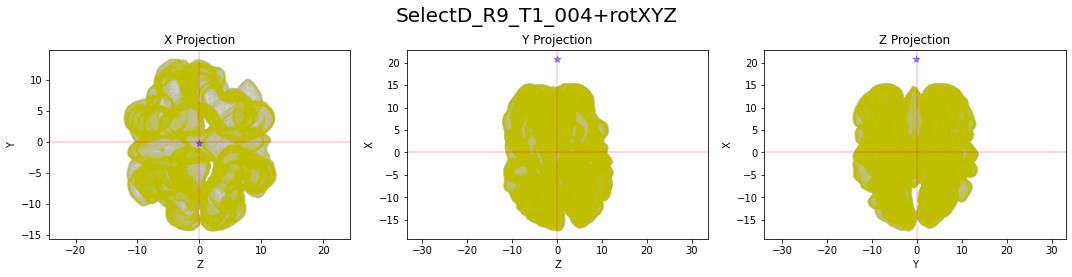

In [16]:
fig, ax = wnut.plot_3Dprojections(datapoints, fname + ' original', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(tipvox[2], tipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(tipvox[2], tipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(tipvox[1], tipvox[0], marker='*', s=50, c='b', alpha=.4);

fig, ax = wnut.plot_3Dprojections(mcoords, fname + '+rotXYZ', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(rtipvox[2], rtipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(rtipvox[2], rtipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(rtipvox[1], rtipvox[0], marker='*', s=50, c='b', alpha=.4);

In [17]:
kminis = np.min(mcoords, axis=1)
kmaxes = np.max(mcoords, axis=1)
print(kmaxes - kminis)

[32.74454975 27.67050669 24.49423366]


In [18]:
khull = spatial.ConvexHull(mcoords.T)
kerlob = khull.area/kerarea
chkervratio = khull.volume/tvols[1]
print(kerlob, 1/kerlob, sep='\t')

0.3627851931703703	2.7564520791519254


### Shell thickness

In [22]:
reload(wnut)
thickness = wnut.object_thickness(extshell, resol)

## Protruding shell

In [55]:
shellvols, _ = np.histogram(protrusion, [2, 4, 6, 10], range=(0,10))

In [64]:
shellvols/np.sum(shellvols)
shellvols*resol**3

array([3533.82451996,  159.95051765,   26.78347182])

## Shell plots

In [44]:
protshell = np.zeros_like(shell, dtype=np.bool)
protshell[protrusion > 5] = True

esnaps = wnut.collapse_dimensions(extshell)
snaps = wnut.collapse_dimensions(shell)
psnaps = wnut.collapse_dimensions(protshell)

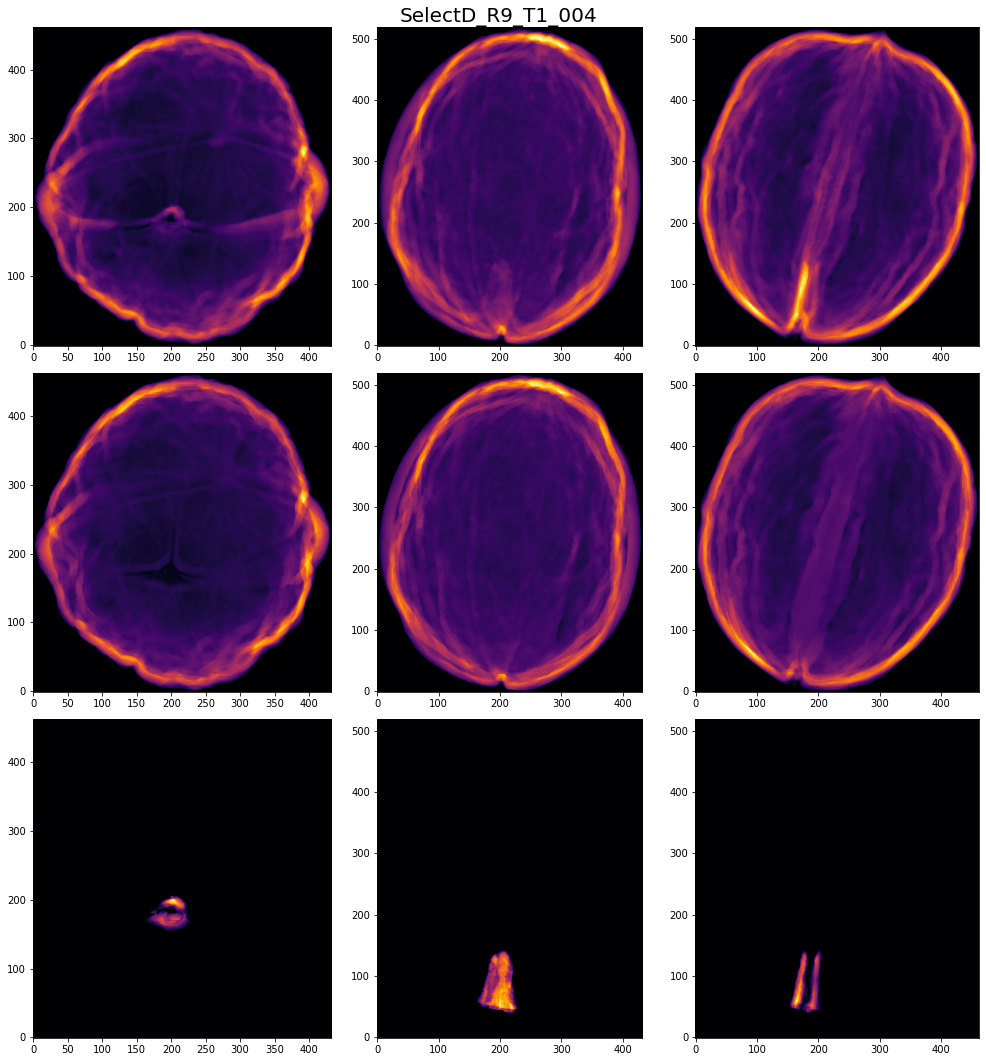

In [48]:
fig, ax = plt.subplots(3,3,figsize=(14,15))
ax = ax.flatten()
for i in range(3):
    ax[i].imshow(snaps[i], cmap='inferno', origin='lower');
    ax[3+i].imshow(esnaps[i], cmap='inferno', origin='lower');
    ax[6+i].imshow(psnaps[i], cmap='inferno', origin='lower');

fig.suptitle(fname, fontsize=20)
fig.tight_layout()

# Data saving

In [69]:
tradpheno = np.hstack((feretd,
                       nutvol,
                       nutva3d, # rugosity ** 3
                       nutferet,
                       1./nutferet, # equancy
                       nutarea,
                       nutsphr, # wadell
                       chnutarea,
                       chnutvol,
                       chnutaratio,
                       chnutvratio,
                       1./chnutaratio,
                       1./chnutvratio,
                       krumbein,
                       corey,
                       sneed,
                       janke,
                       wadell,
                       tvols,
                       tvolr,
                       shellrug, # 1/wadell
                       thickness,
                       shellvols/np.sum(shellvols),
                       shellvols*resol**3,
                       kmaxes - kminis,
                       kerarea,
                       khull.volume,
                       khull.area,
                       kerlob,
                       1./kerlob,
                       chkervratio,
                       1./chkervratio))
print(tradpheno.shape)

filename = wdst + fname + '_trad.csv'
print(filename)
foo = pd.DataFrame([bname, fname.split('_')[-1], *tradpheno]).T
foo.to_csv(filename, header=False, index=False)

(49,)
../hpcc/traditional/SelectD_R9_T1/SelectD_R9_T1_004_trad.csv


In [66]:
bar = pd.read_csv(filename, header=None, dtype={1:str})

In [67]:
bar

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,SelectD_R9_T1,004,40.536539,33.951642,32.513575,21060.565125,4.703385,1.246757,0.802081,6179.229152,...,32.74455,27.670507,24.494234,7703.389697,13071.75442,2794.675719,0.362785,2.756452,1.742032,0.574042
